# Pipeline de demonstração do EA‑VRP.

Gera dados sintéticos (passageiros, veículos, pontos de recarga), executa o
agrupamento geográfico e imprime no console a composição de cada grupo.

Uso
---
```
$ docker compose up 
```

In [1]:
import random
from typing import List

from geografics import generate_random_geografic_points
from grouping import GeoGrouper, EAVRPGroup
from utils import Passenger, Vehicle, RechargePoint, Depot
from encoder import QUBOEncoder
from solver import QAOASolver
from graph import build_graph

from pathlib import Path

## Helpers de geração sintética

In [2]:
def make_passengers(n: int, x_lim: List, y_lim: List) -> List[Passenger]:
    """Cria *n* passageiros com origem e destino aleatórios."""
    origin = generate_random_geografic_points(n, x_lim, y_lim)
    dest = generate_random_geografic_points(n, x_lim, y_lim)
    passengers: List[Passenger] = []
    for i, (o, d) in enumerate(zip(origin,dest)):
        passengers.append(Passenger(id=i, origin=o, destination=d))
    return passengers

In [3]:
def make_vehicles(n: int) -> List[Vehicle]:
    """Cria *n* veículos com parâmetros padrão."""
    return [Vehicle(id=i + 1) for i in range(n)]

In [4]:
def make_depot(n: int, x_lim: List, y_lim: List) -> List[RechargePoint]:
    origin = generate_random_geografic_points(n, x_lim, y_lim)
    recharge_points: List[RechargePoint] = []
    for i, o in enumerate(origin):
        recharge_points.append(Depot(id=i, location=o))
    return recharge_points

In [5]:
def make_recharge_points(n: int, x_lim: List, y_lim: List) -> List[RechargePoint]:
    origin = generate_random_geografic_points(n, x_lim, y_lim)
    recharge_points: List[RechargePoint] = []
    for i, o in enumerate(origin):
        recharge_points.append(RechargePoint(id=i, location=o))
    return recharge_points

In [6]:
OUTDIR = Path("figs")
OUTDIR.mkdir(parents=True, exist_ok=True)

n_passengers = 5
n_vehicles = 2
n_recharge_points = 1

In [7]:
p=2
shots=1000
steps=15
diameter = 0.2 # 1 => 100kmprint(depot)
shrink_epsilon = 0.9 # None

In [8]:
seed = 42
filename_hist = OUTDIR / "teste_histograma.png" # nome do arquivo do histograma
filename_graph = OUTDIR / "teste_grafo.png" # nome do arquivo do grafo

In [9]:
xlim, ylim = (-24, -23.4), (-46.8, -46.3)
passengers = make_passengers(n_passengers, xlim, ylim)
vehicles = make_vehicles(n_vehicles)
recharge_points = make_recharge_points(n_recharge_points, xlim, ylim)
depot = make_depot(1, xlim, ylim)
print(depot)

## Agrupamento de Passageiros

In [10]:
grouper = GeoGrouper(delta=diameter)
groups = grouper.fit(passengers)

for g in groups:
    p_ids = [passenger.id for passenger in g.passengers]
    print(f"Grupo {g.id:02d} | {len(p_ids)} passageiros -> {p_ids}")

total_qubits = len(groups)  # variável por grupo (modelo futuro)
print(f"Total de grupos (≈ qubits na formulação): {total_qubits}")

Grupo 01 | 1 passageiros -> [0]
Grupo 02 | 1 passageiros -> [1]
Grupo 03 | 1 passageiros -> [2]
Grupo 04 | 1 passageiros -> [3]
Grupo 05 | 1 passageiros -> [4]
Total de grupos (≈ qubits na formulação): 5


In [11]:
# QUBO para somente grupos sem compressão
encoder = QUBOEncoder(vehicles, 
                             groups, 
                             recharge_points,
                             depot=depot
                            )
encoder_passengers = QUBOEncoder(vehicles, 
                             passengers, 
                             recharge_points, 
                             depot=depot
                            )

In [12]:
print(f"Quantidade de qubits com grupos: {encoder.num_qubits}")
print(f"Quantidade de qubits sem grupos: {encoder_passengers.num_qubits}")

Quantidade de qubits com grupos: 12
Quantidade de qubits sem grupos: 12


In [13]:
print("Matriz QUBO (valores arredondados a 2 casas decimais):")
encoder.print_matrix(precision=2)

Matriz QUBO (valores arredondados a 2 casas decimais):
[[-1.17  0.    0.    0.    0.    0.    4.53  0.    0.    0.    0.    0.  ]
 [ 0.   -1.79  0.    0.    0.    0.    0.    4.53  0.    0.    0.    0.  ]
 [ 0.    0.   -1.13  0.    0.    0.    0.    0.    4.53  0.    0.    0.  ]
 [ 0.    0.    0.   -1.36  0.    0.    0.    0.    0.    4.53  0.    0.  ]
 [ 0.    0.    0.    0.   -1.92  0.    0.    0.    0.    0.    4.53  0.  ]
 [ 0.    0.    0.    0.    0.    0.36  0.    0.    0.    0.    0.    0.  ]
 [ 4.53  0.    0.    0.    0.    0.   -1.17  0.    0.    0.    0.    0.  ]
 [ 0.    4.53  0.    0.    0.    0.    0.   -1.79  0.    0.    0.    0.  ]
 [ 0.    0.    4.53  0.    0.    0.    0.    0.   -1.13  0.    0.    0.  ]
 [ 0.    0.    0.    4.53  0.    0.    0.    0.    0.   -1.36  0.    0.  ]
 [ 0.    0.    0.    0.    4.53  0.    0.    0.    0.    0.   -1.92  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.36]]


In [14]:
print("Matriz QUBO Somente passageiros (valores arredondados a 2 casas decimais):")
encoder_passengers.print_matrix(precision=2)

Matriz QUBO Somente passageiros (valores arredondados a 2 casas decimais):
[[-1.17  0.    0.    0.    0.    0.    4.53  0.    0.    0.    0.    0.  ]
 [ 0.   -1.79  0.    0.    0.    0.    0.    4.53  0.    0.    0.    0.  ]
 [ 0.    0.   -1.13  0.    0.    0.    0.    0.    4.53  0.    0.    0.  ]
 [ 0.    0.    0.   -1.36  0.    0.    0.    0.    0.    4.53  0.    0.  ]
 [ 0.    0.    0.    0.   -1.92  0.    0.    0.    0.    0.    4.53  0.  ]
 [ 0.    0.    0.    0.    0.    0.36  0.    0.    0.    0.    0.    0.  ]
 [ 4.53  0.    0.    0.    0.    0.   -1.17  0.    0.    0.    0.    0.  ]
 [ 0.    4.53  0.    0.    0.    0.    0.   -1.79  0.    0.    0.    0.  ]
 [ 0.    0.    4.53  0.    0.    0.    0.    0.   -1.13  0.    0.    0.  ]
 [ 0.    0.    0.    4.53  0.    0.    0.    0.    0.   -1.36  0.    0.  ]
 [ 0.    0.    0.    0.    4.53  0.    0.    0.    0.    0.   -1.92  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.36]]


In [15]:
print(f"Offset com compressão (constante): {encoder.offset:.2f}")

Offset com compressão (constante): 11.33


In [16]:
# 3) QAOA 
solver = QAOASolver(encoder,
                    p=p,
                    shots=shots,
                    steps=steps,
                    dev="lightning.qubit", # "default.qubit"
                    seed=seed)
best_bits, best_cost = solver.solve()

/opt/conda/lib/python3.11/site-packages/pennylane/_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


In [17]:
# Estado inteiro x (LSB = qubit 0)
x_val = int("".join(map(str, best_bits[::-1])), 2)
print(f"Melhor estado: |{x_val}⟩  ==> custo {best_cost:.2f}\n")

Melhor estado: |1543⟩  ==> custo 3.96



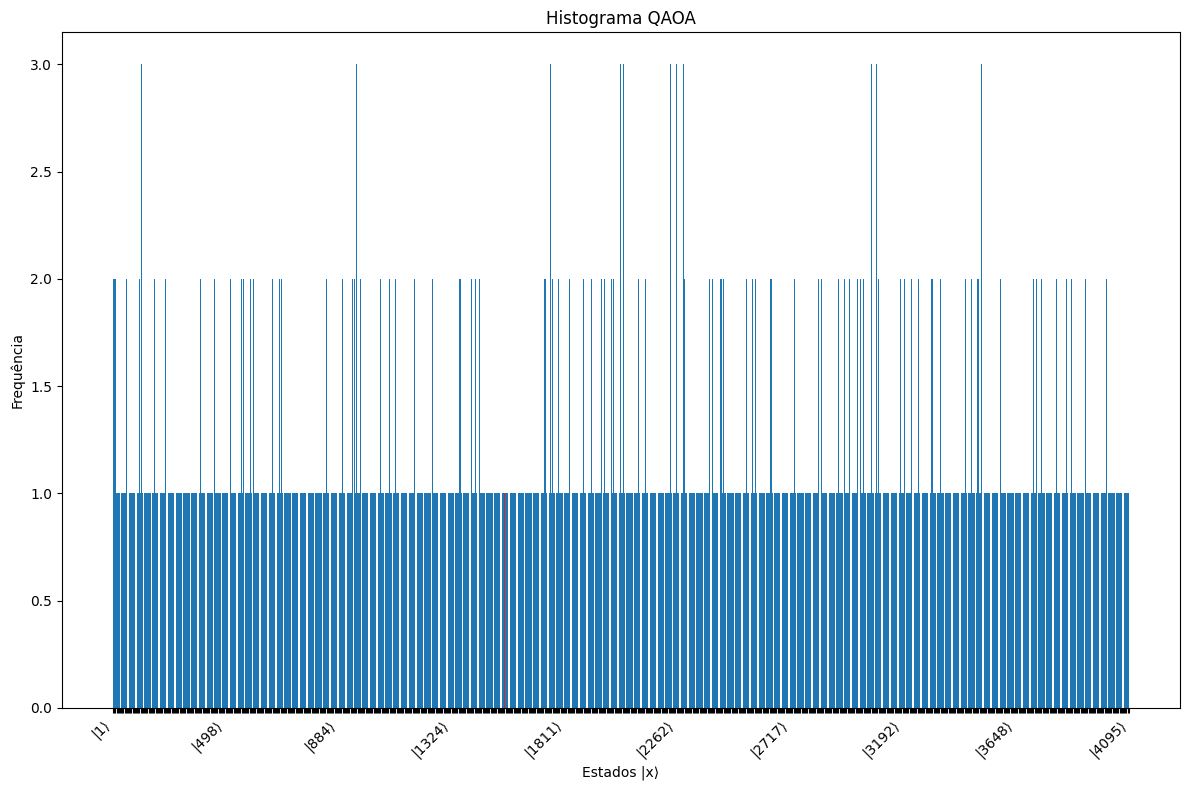

Histograma salvo em: figs/teste_histograma.png


In [18]:
# 4) Histograma
solver.plot_histogram(filename_hist)
print(f"Histograma salvo em: {filename_hist}")

/home/jovyan/work/graph.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


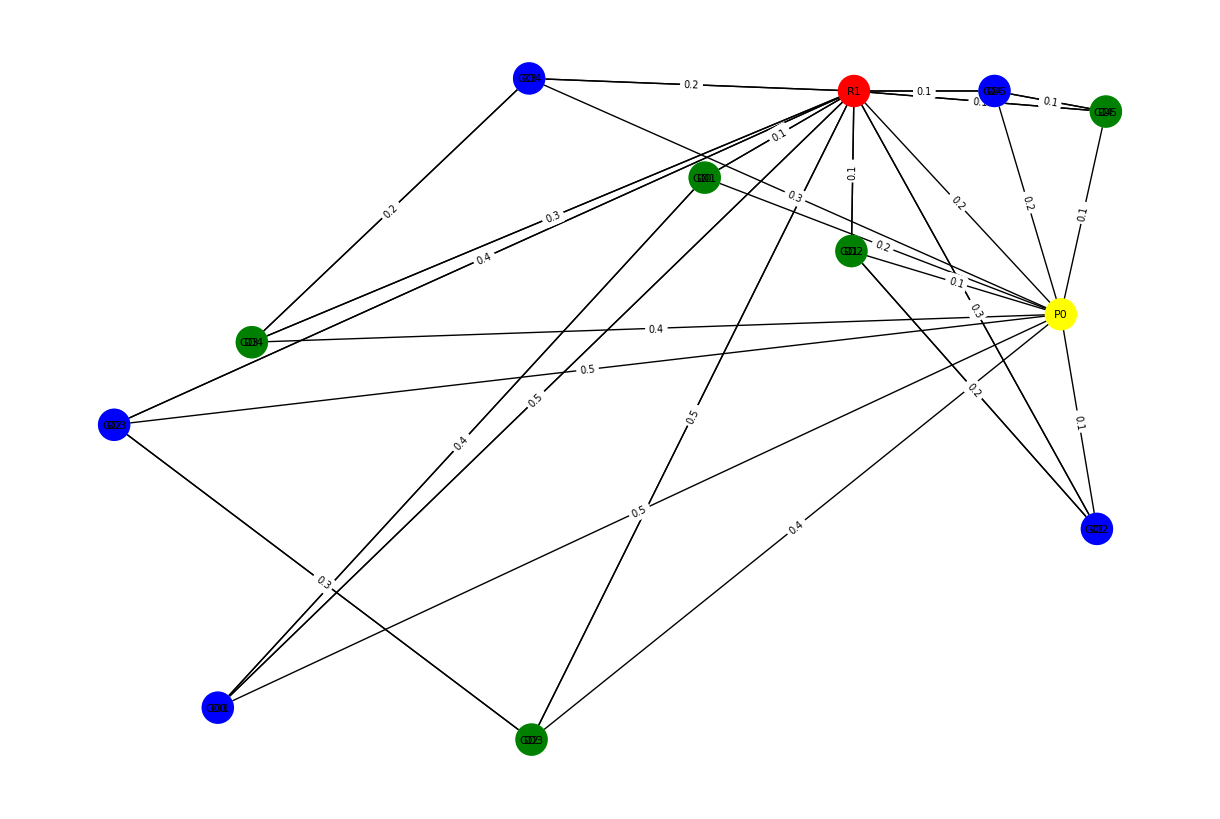

Grafo salvo em: figs/teste_grafo.png


In [19]:
build_graph(passengers, groups, recharge_points, depot, filename_graph)
print(f"Grafo salvo em: {filename_graph}")